Much of below code identical to cloobvis notebook. Main difference is addition of a loader that can simplify loading embeddings as if they themselves are the dataset.

In [4]:
import torch
import sys
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.functional import normalize

from carp.configs import CARPConfig
from carp.pytorch.model.architectures import *
from carp.pytorch.data import *

In [5]:
CHUNK_SIZE = 512
N_CTX = 512

In [7]:
# Lots of stuff from before now encapsulated in this loader class
# Load model
config = CARPConfig.load_yaml("../../../configs/carp_cloob.yml")
cloob_model = CARPCloob(config.model)
cloob_model.load("CLOOB_CP/")
cloob_model = cloob_model.cuda()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaMod

In [8]:
# Loader to forward pass and embed embeddings
class Loader:
    def __init__(self):
        pipeline = BaseDataPipeline(path="../../dataset")
        self.passages = pipeline.passages
        self.reviews = pipeline.reviews
        
        self.N = len(self.passages) # assume this is equal to len(reviews)
        self.ind = 0
        
        self.preproc()
        self.shuffle()
    
    def preproc(self):
        self.passages = [passage[-N_CTX:] for passage in self.passages]
        self.reviews = [review[-N_CTX:] for review in self.reviews]
        
    def shuffle(self):
        inds = torch.randperm(self.N)
        self.passages = [self.passages[ind] for ind in inds]
        self.reviews = [self.reviews[ind] for ind in inds]
    
    def __iter__(self):
        return self
    
    def __next__(self):
        # Get batch
        passages = self.passages[self.ind * CHUNK_SIZE : (self.ind+1) * CHUNK_SIZE]
        reviews = self.reviews[self.ind * CHUNK_SIZE : (self.ind+1) * CHUNK_SIZE]
        
        # Tokenize
        tokenize = cloob_model.passage_encoder.call_tokenizer
        p_tok_out = tokenize(passages)
        r_tok_out = tokenize(reviews)
        p_input_ids = p_tok_out["input_ids"]
        p_masks = p_tok_out["attention_mask"]
        r_input_ids = r_tok_out["input_ids"]
        r_masks = r_tok_out["attention_mask"]
        
        p_input = BatchElement(p_input_ids, p_masks)
        r_input = BatchElement(r_input_ids, r_masks)
        
        with torch.no_grad():
            pass_encs, rev_encs = \
                cloob_model.calculate_embeddings([p_input], [r_input])
        
        postproc = lambda x: normalize(x[0].float()).cpu().detach().half()
        
        pass_encs = postproc(pass_encs)
        rev_encs = postproc(rev_encs)
        
        self.ind += 1
        
        return pass_encs, rev_encs
    
    next = __next__
            

In [9]:
loader = Loader()

In [13]:
# Allocate tensors to store all passage and rev encodings
P = torch.zeros(loader.N, 2048, dtype = torch.half)
R = torch.zeros(loader.N, 2048, dtype = torch.half)

In [14]:
from tqdm import tqdm

# on 3090 ~45 minutes
i = 0
for (pass_encs, rev_encs) in tqdm(loader):
    P[i:i + CHUNK_SIZE] = pass_encs
    R[i:i + CHUNK_SIZE] = rev_encs

    i+=CHUNK_SIZE
    if (i//CHUNK_SIZE) >= 50: break # for this example, don't do it all

49it [00:49,  1.01s/it]


In [15]:
P = P[:i]
R = R[:i]

# UMAP

In [18]:
import umap
reducer = umap.UMAP()

In [19]:
P_embed = reducer.fit_transform(P)
R_embed = reducer.fit_transform(R)

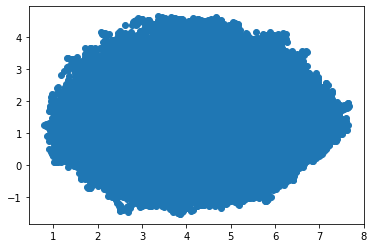

In [22]:
plt.scatter(embedding[:,0], embedding[:,1])

In [23]:
embedding.shape

(25600, 2)